# Grouping municipalities and merging attractors

In this script we group the municipalitites based their distance to the attractor municipalities and merge the existing groups based on any overlapping attractor municipalities that belong in multiple groups.

In the first stage (before developing a time radius), we find a cartesian radius proportional to the area of each attractor municipality. We then find the municipalities that fall within a circle with such radius and center on the centroid of the attractor municipality. The output of this is a binary csv file with 1 signifying part of the region with the attractor municipality in the column heading and 0 otherwise.

Secondly, we identify which attractor municipalities fall within the regionalization radius of other attractor municipalities. We update the output csv from before to have 2 signify an attractor municipality being within the regionalization radius of another attractor, 1 signify a non-attractor municipality being within region, and 0 otherwise. 

In [42]:
# Libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import math

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN

import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial

import json
from shapely.geometry import Point, mapping
from shapely.ops import transform

import random

# Paths and names

In [2]:
# Define path of municipalities shape file

# this is allison's path
# entities_path = 'marco_geoestadistico_2018/'

# this is jerry's path
entities_path = '../marco_geoestadistico_2018/'


In [3]:
# Define a dictionary to read the shape files

entities= {
    '01' :['01Ags','01_aguascalientes'],
    '02' :['02BC','02_bajacalifornia'],
    '03' :['03BCS','03_bajacaliforniasur'],
    '04' :['04Camp', '04_campeche'],
    '05' :['05Coah','05_coahuiladezaragoza'],
    '06' :['06Col','06_colima'],
    '07' :[ '07Chs','07_chiapas'],
    '08' :['08Chih','08_chihuahua'],
    '09' :['09CdMx','09_ciudaddemexico'],
    '10' :['10Dur','10_durango'],
    '11' :['11Gto', '11_guanajuato'],
    '12' :['12Gro','12_guerrero'],
    '13' :['13Hgo','13_hidalgo'],
    '14' :['14Jal','14_jalisco'],
    '15' :['15EdoMex','15_mexico'],
    '16' :['16Mich','16_michoacandeocampo'],
    '17' :['17Mor','17_morelos'],
    '18' :['18Nay','18_nayarit'],
    '19' :['19NL', '19_nuevoleon'],
    '20' :['20Oax', '20_oaxaca'],
    '21' :['21Pue', '21_puebla'],
    '22' :['22Qro','22_queretaro'],
    '23' :['23QRoo','23_quintanaroo'], 
    '24' :['24SLP','24_sanluispotosi'],
    '25' :['25Sin','25_sinaloa'],
    '26' :['26Son','26_sonora'],
    '27' :['27Tab','27_tabasco'],
    '28' :['28Tamps','28_tamaulipas'],
    '29' :['29Tlax','29_tlaxcala'],
    '30' :['30Ver','30_veracruzignaciodelallave'],
    '31' :[ '31Yuc','31_yucatan'],
    '32' :[ '32Zac','32_zacatecas']   
}

# Municipality shapefiles

In [4]:
# Read in municipality shapefiles 

urban_shapes = []

for i in range(1,33):
    a = str(i).zfill(2)
    
    urban_agebs = gpd.read_file(entities_path + entities[a][1]+'/conjunto de datos/'+entities[a][1][0:2]+'mun'+'.shp')
    
    urban_shapes.append(urban_agebs)
    
urban_shapes = pd.concat(urban_shapes)

# Area and centroid calculations

In [5]:
# Find area of all municipalities

# Ensure projection consistency
urban_shapes = urban_shapes.to_crs({'init' :'epsg:4326'})

gs = gpd.GeoSeries(urban_shapes['geometry'])

areas = []
for i in gs:  
    area = ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea',
                lat_1=i.bounds[1],
                lat_2=i.bounds[3])),
        i)
    areas.append(area.area/1000000)
    
urban_shapes['area'] = areas

In [6]:
# Find centroid of all municipalities

centroid = gs.centroid
urban_shapes['centroid'] = centroid

# Radius calculations for attractor municipalities

In [7]:
# Read in attractor municipalities

attractors = pd.read_csv('complejidad_alta.csv')

# Standardize ID number
for i in range(0,137):
    attractors['cve_mun'].iloc[i] = str(attractors['cve_mun'].iloc[i]).zfill(5)

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
# Find radius for each municipality

att_shapes = urban_shapes.loc[urban_shapes['CVEGEO'].isin(attractors['cve_mun'])]

min_area = att_shapes['area'].min()

radius = []
for i in range(0,137):
    area = att_shapes['area'].iloc[i]
    radius.append(50*(math.log(area/min_area,10) + 1))
    
att_shapes['radius'] = radius

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


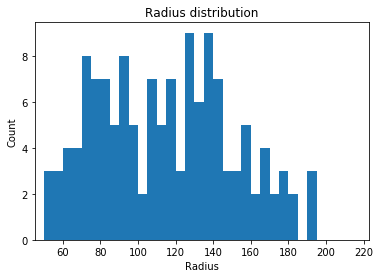

In [9]:
# Show radius distribution

bins = np.arange(0, 200, 5) # fixed bin size

plt.xlim([min(radius)-5, max(radius)+5])

plt.hist(radius, bins=bins)
plt.title('Radius distribution')
plt.xlabel('Radius')
plt.ylabel('Count')

plt.show()

# Regionalization using radius

In [10]:
# Create a circle with center at the centroid of each attractor municipality and corresponding radius

import math

polygon_list = []
    
def find_circle(point, radius_individual):

    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )
    
    point_transformed = transform(wgs84_to_aeqd, point)

    buffer = point_transformed.buffer(radius_individual*1000)

    buffer_wgs84 = transform(aeqd_to_wgs84, buffer)

    return (Polygon(buffer_wgs84))

for i in range(att_shapes.shape[0]):
    
    polygon_list.append(find_circle(att_shapes['centroid'].iloc[i],att_shapes['radius'].iloc[i]))

att_shapes['circlerange'] = polygon_list

/Users/ruijiehuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# Output csv

phase_1 = urban_shapes

for t in range(att_shapes.shape[0]):
    one_column = []
    
    check_polygon = att_shapes['circlerange'].iloc[t]
    
    for i in range(urban_shapes.shape[0]):
        
        check_point = (urban_shapes['centroid'].iloc[i])
        
        if urban_shapes['CVEGEO'].iloc[i] in attractors['cve_mun'].unique():
            dummy_value = 2 * (check_polygon.contains(check_point))
        else:
            dummy_value = 1 * (check_polygon.contains(check_point))
        
        one_column.append(dummy_value)
    
    temp_str = att_shapes['CVEGEO'].iloc[t]
    
    phase_1[temp_str] = one_column
    
phase_1 = phase_1.drop(['geometry', 'centroid'], axis=1)

export_csv = phase_1.to_csv('phase_1.csv')

# Distribution of overlaps

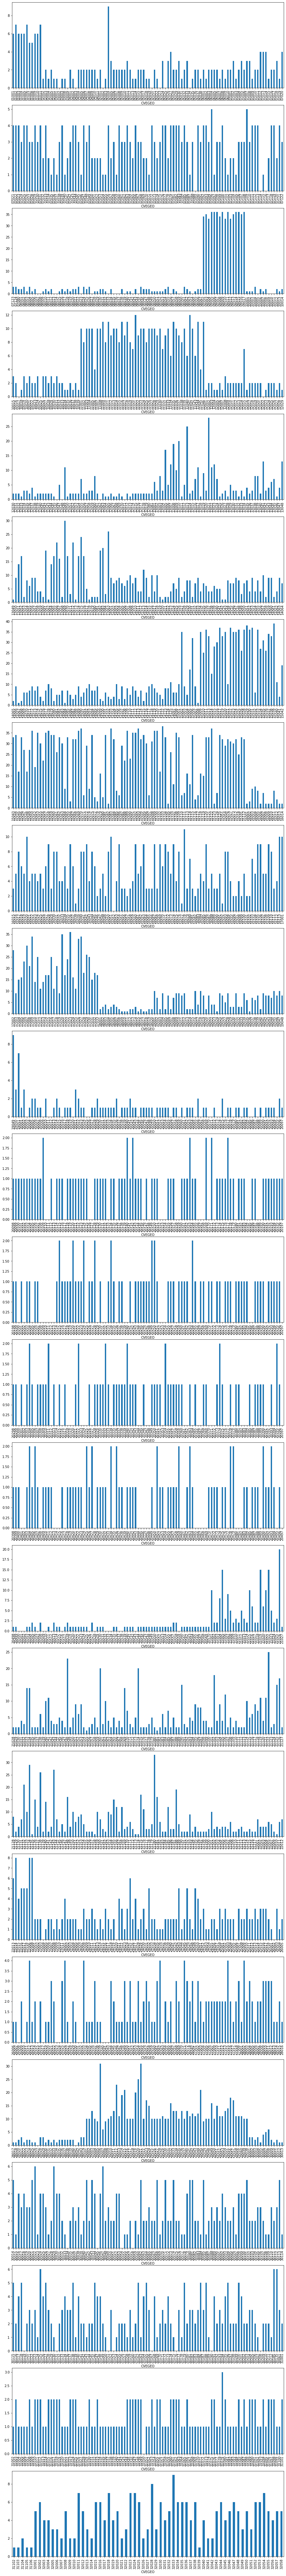

In [12]:
# Plot number overlaps for all municipalities

overlap = phase_1.drop(['CVE_ENT', 'CVE_MUN', 'NOMGEO', 'area'], axis=1)

overlap.set_index('CVEGEO', inplace=True)

overlap_t = overlap.T

overlap_count = overlap_t.astype(bool).sum()

for i in attractors['cve_mun']:
    overlap_count[i] = overlap_count[i] - 1
    
fig, axes = plt.subplots(nrows=25)ho

for i in range(25):
    overlap_count_sample = overlap_count.iloc[i*100:i*100+100]
    overlap_count_sample.plot.bar(ax=axes[i], figsize=(15,145), rot=90);

In [13]:
# Summary of all overlaps

overlap_count.describe()

count    2463.000000
mean        4.919204
std         7.394339
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        39.000000
dtype: float64

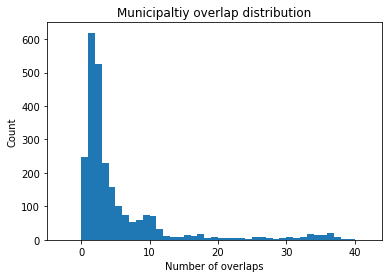

In [14]:
# Distribution histogram of all overlaps

bins = np.arange(0, 50, 1) # fixed bin size

plt.xlim([min(overlap_count)-5, max(overlap_count)+5])

plt.hist(overlap_count, bins=bins)
plt.title('Municipaltiy overlap distribution')
plt.xlabel('Number of overlaps')
plt.ylabel('Count')

plt.show()

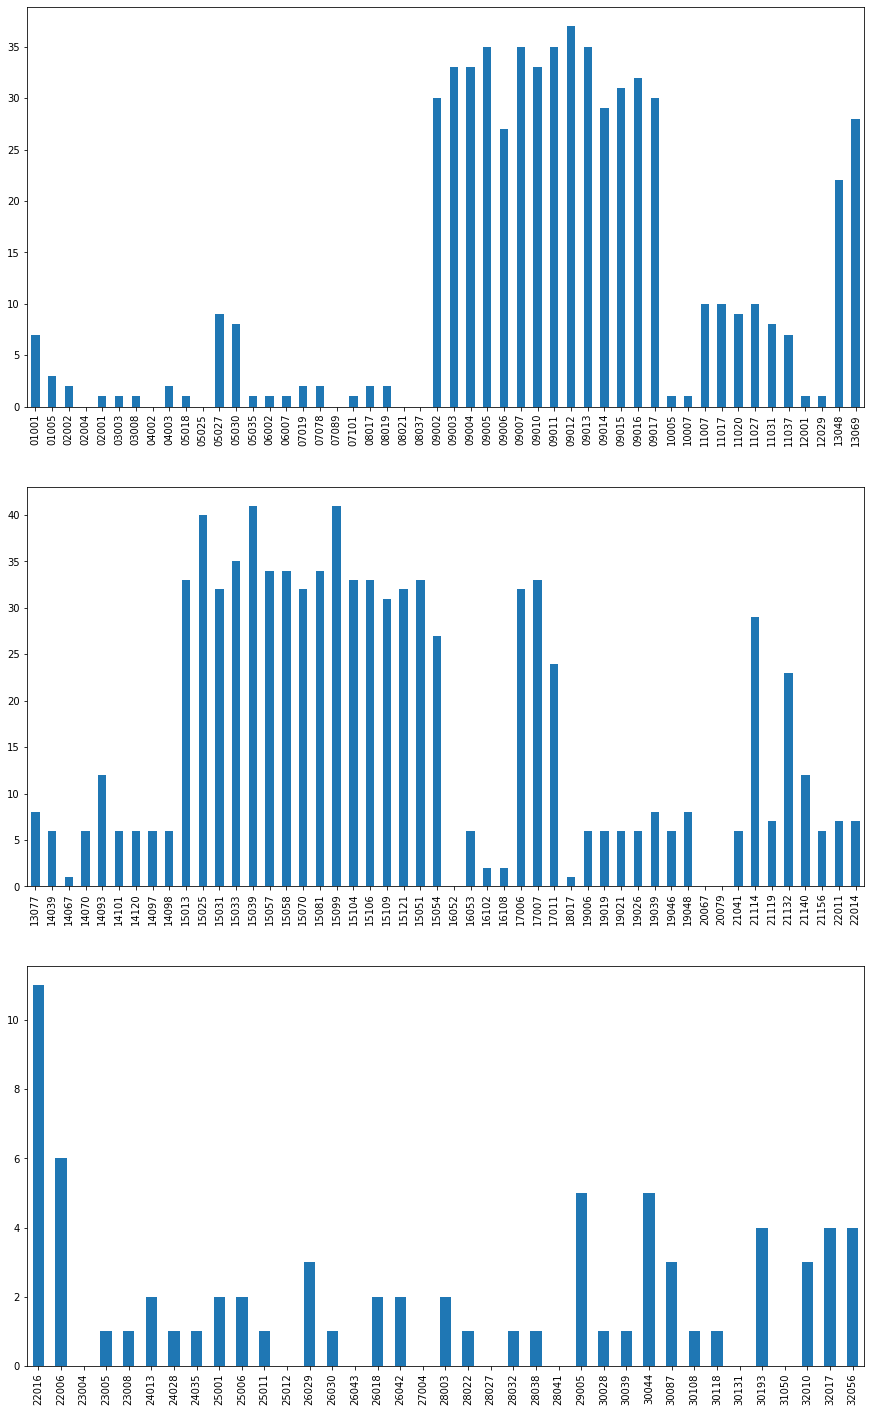

In [15]:
# Plot number overlaps for attractor municipalities

att_only = phase_1.loc[phase_1['CVEGEO'].isin(attractors['cve_mun'])]

att_only = att_only.drop(['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'NOMGEO', 'area'], axis=1)

att_overlap_count = att_only.astype(bool).sum()

att_overlap_count = att_overlap_count - 1
    
fig, axes = plt.subplots(nrows=3)

for i in range(3):
    att_overlap_count_sample = att_overlap_count.iloc[i*50:i*50+50]
    att_overlap_count_sample.plot.bar(ax=axes[i], figsize=(15,25), rot=90);

In [16]:
# Summary of attractor overlaps

att_overlap_count.describe()

count    137.000000
mean      11.153285
std       13.323404
min        0.000000
25%        1.000000
50%        6.000000
75%       24.000000
max       41.000000
dtype: float64

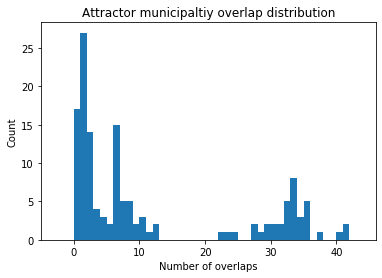

In [17]:
# Distribution histogram of attractor overlaps

bins = np.arange(0, 60, 1) # fixed bin size

plt.xlim([min(att_overlap_count)-5, max(att_overlap_count)+5])

plt.hist(att_overlap_count, bins=bins)
plt.title('Attractor municipaltiy overlap distribution')
plt.xlabel('Number of overlaps')
plt.ylabel('Count')

plt.show()

# Merging regions

In [18]:
# Naively merge all attractor regions that overlap with other attractors

Reg_dict = {}

for att in overlap.columns:
    Reg_dict[att] = 0

i = 0

merged = pd.DataFrame(index = overlap.index)
for col in overlap.columns:
    l = overlap.index[overlap[col] == 2].tolist()
    regions = []
    for att in l:
        if Reg_dict[att] != 0:
            regions.append(Reg_dict[att])
    if regions == []:
        i += 1
        for att in l:
            Reg_dict[att] = i
            merged[i] = overlap[att]
    else:
        region = min(set(regions))
        for att in l:
            Reg_dict[att] = region
            merged[region] = merged[region] + overlap[att]

In [19]:
# Create dictionary documenting naive regionalization

Reg_dict_naive = {}

for col in merged.columns:
    Reg_dict_naive[col] = merged.index[merged[col] > 0].tolist()

In [ ]:
urban_shapes.set_index("CVEGEO", inplace = True)

No handles with labels found to put in legend.


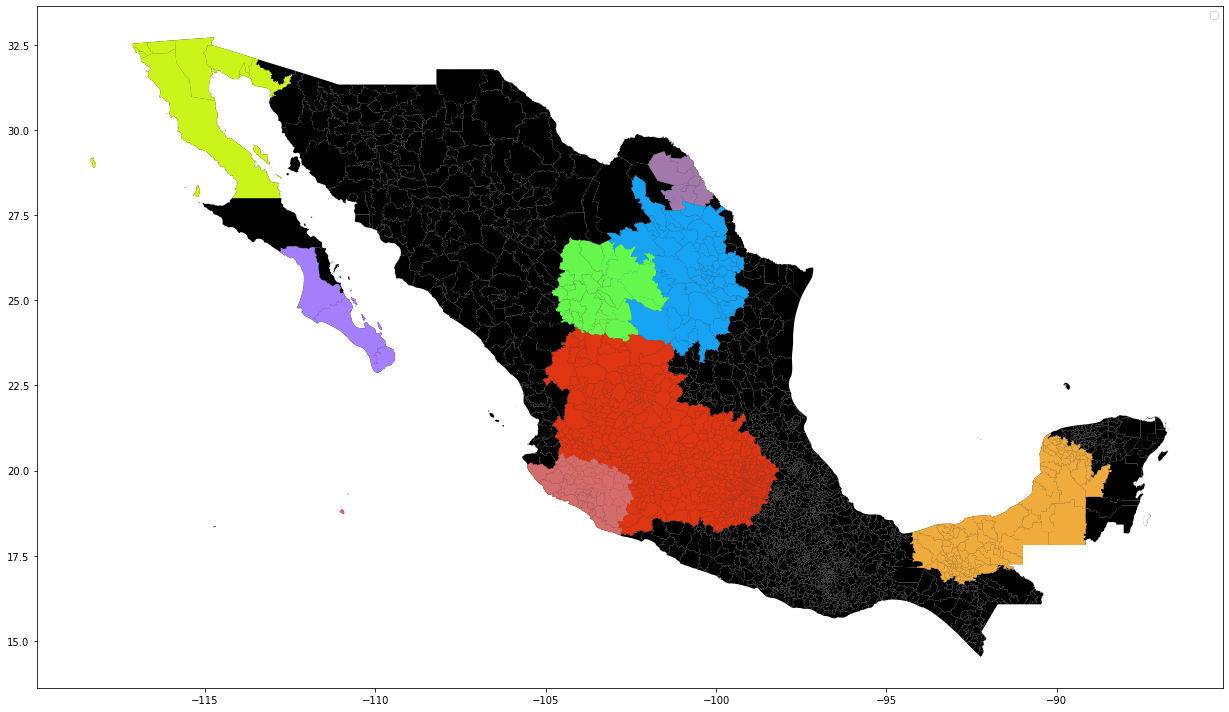

In [49]:
fig, ax = plt.subplots(figsize=(20,10))

(urban_shapes).plot(ax=ax, color='black');

# color_list = ['g','r','c','m', 'y', 'k', 'w','g', 'orange','c','m', 'y', 'k', 'w','g','r','c','m', 'y', 'k', 'w','g','r','c','m', 'y', 'k', 'w','g','r','c','m', 'y', 'k', 'w','g','r','c','m', 'y', 'k', 'w','g','r','c','m', 'y', 'k', 'w']

import random
def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return ("#"+color)

    
for i in range (1,9):
    
    loc_num = Reg_dict_naive[i]
    
    (urban_shapes.loc[loc_num,:]).plot(ax=ax, color=randomcolor())
    
plt.legend()

plt.tight_layout();

In [20]:
# Merge attractor regions that overlap with other attractors by complexity, 1 merge per attractor

Reg_dict = {}
Merge_dict = {}

for att in overlap.columns:
    Reg_dict[att] = 0
    
for att in overlap.columns:
    Merge_dict[att] = 0

i = 0

merged = pd.DataFrame(index = overlap.index)

for col in attractors['cve_mun']:
    if Merge_dict[col] == 0:
        i += 1
        l = overlap.index[overlap[col] == 2].tolist()
        merged[i] = overlap[col]
        for att in l:
            Merge_dict[att] = 1
            merged[i] = merged[i] + overlap[att]

In [21]:
# Create dictionary documenting 1-pass regionalization

Reg_dict1 = {}

for col in merged.columns:
    Reg_dict1[col] = merged.index[merged[col] > 0].tolist()

In [50]:
Reg_dict1

{1: ['01001',
  '01003',
  '01005',
  '11001',
  '11008',
  '11012',
  '11016',
  '11020',
  '11023',
  '11025',
  '11026',
  '11031',
  '11037',
  '14001',
  '14002',
  '14003',
  '14004',
  '14005',
  '14006',
  '14007',
  '14008',
  '14009',
  '14010',
  '14011',
  '14012',
  '14013',
  '14014',
  '14016',
  '14017',
  '14018',
  '14019',
  '14023',
  '14024',
  '14026',
  '14028',
  '14029',
  '14030',
  '14031',
  '14032',
  '14033',
  '14034',
  '14035',
  '14036',
  '14037',
  '14038',
  '14039',
  '14040',
  '14044',
  '14045',
  '14046',
  '14047',
  '14048',
  '14050',
  '14051',
  '14052',
  '14053',
  '14054',
  '14055',
  '14056',
  '14057',
  '14059',
  '14060',
  '14062',
  '14063',
  '14066',
  '14069',
  '14070',
  '14071',
  '14072',
  '14073',
  '14074',
  '14075',
  '14076',
  '14077',
  '14078',
  '14079',
  '14082',
  '14083',
  '14085',
  '14086',
  '14088',
  '14089',
  '14090',
  '14091',
  '14092',
  '14093',
  '14094',
  '14095',
  '14096',
  '14099',
  '1410

No handles with labels found to put in legend.


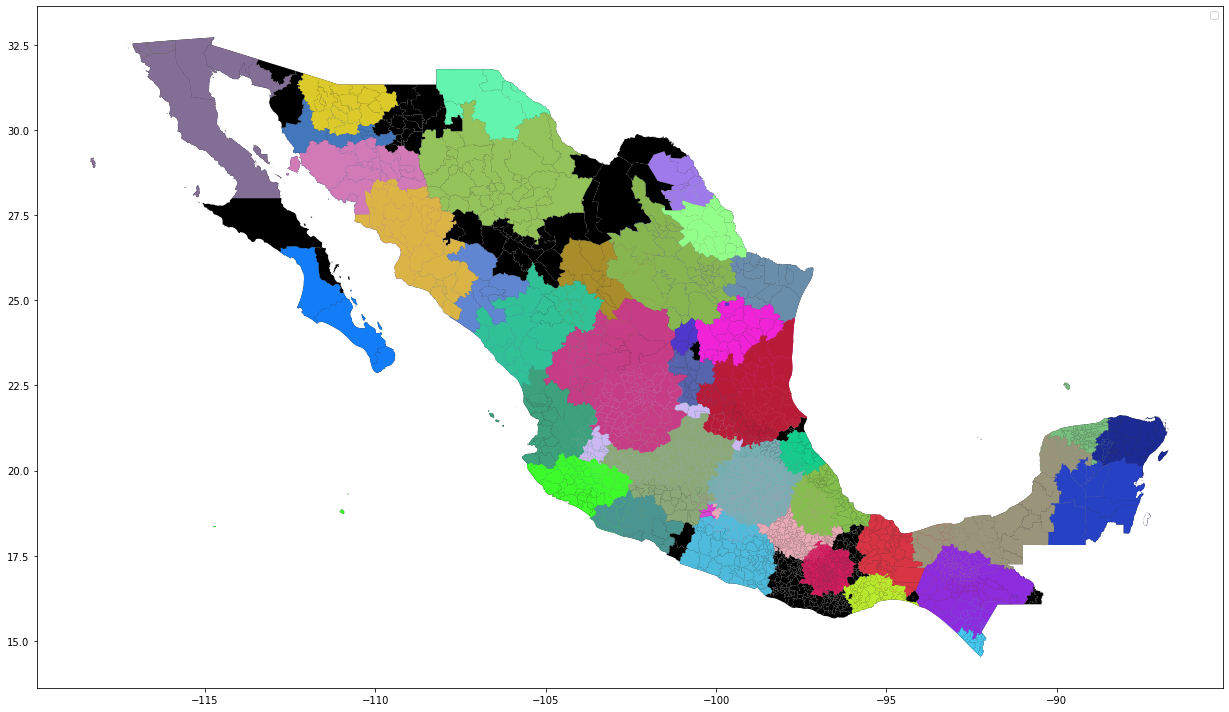

In [51]:
fig, ax = plt.subplots(figsize=(20,10))

(urban_shapes).plot(ax=ax, color='black');

for i in range (1,47):
    
    loc_num = Reg_dict1[i]
    
    (urban_shapes.loc[loc_num,:]).plot(ax=ax, color=randomcolor())
    
plt.legend()

plt.tight_layout();